**Importing libraries**

In [ ]:
import numpy as np
import keras
from keras import *
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print("Libraries imported")

Found GPU at: /device:GPU:0
Libraries imported


**Mounting the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the dataset**

In [ ]:
dataset = '/content/drive/MyDrive/ML_HW3/africa_fabric/'

X=[]

for f in os.listdir(dataset):
  image = Image.open(os.path.join(dataset,f))
  data = np.asarray(image)
  X.append(data)

X_train = np.asarray(X)

**Showing random sample of the dataset**

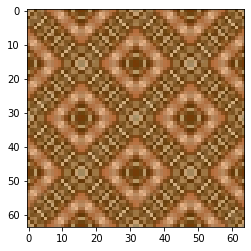

In [ ]:
i = random.randrange(0,X_train.shape[0])
image = X_train[i]/255
image = np.array(image, dtype='float')
plt.imshow(image)
plt.show()

**Defining the GAN**

In [ ]:
class GAN():

  def __init__(self, latent_dim=128):
    
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    optimizer=Adam(lr=0.0002, beta_1=0.5)
    disc_fn = self.build_discriminator_CNN
    gen_fn = self.build_generator_CNN

    self.discriminator = disc_fn()
    self.discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer, metrics=['accuracy'])
    
    self.latent_dim = latent_dim
    self.Goutact = 'sigmoid'

    self.generator = gen_fn()
    self.generator.compile(loss='mse', optimizer=optimizer)

    self.discriminator.trainable = False

    self.combined = Sequential()
    self.combined.add(self.generator)
    self.combined.add(self.discriminator)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    plot_model(self.discriminator, to_file='/content/drive/MyDrive/ML_HW3/D.png', show_shapes=True, show_layer_names=True)
    plot_model(self.generator, to_file='/content/drive/MyDrive/ML_HW3/G.png', show_shapes=True, show_layer_names=True)
    plot_model(self.combined, to_file='/content/drive/MyDrive/ML_HW3/GAN.png', show_shapes=True, show_layer_names=True)

    self.X_train = X_train
    self.X_train = self.X_train.astype(np.float32) / 255.0

    self.epoch = 0

  def build_generator_CNN(self):

    noise_shape = (self.latent_dim,)
    n_nodes = 128 * 8 * 8
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (8,8), activation=self.Goutact, padding='same'))

    return model

  def build_discriminator_CNN(self):

    img_shape = self.img_shape

    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

  def train(self, epochs, batch_size=128, save_interval=100, show_img=False):

    half_batch = int(batch_size / 2)
 
    last_epoch = self.epoch + epochs

    self.save_imgs(self.epoch)
    self.d_loss = []
    self.g_loss = []

    while self.epoch < last_epoch:
 
      idx = np.random.randint(0, self.X_train.shape[0], half_batch)
      imgs = self.X_train[idx]
      y_imgs = np.ones((half_batch, 1))
 
      noise = np.random.normal(0, 1, (half_batch, self.latent_dim))
      gen_imgs = self.generator.predict(noise)
      y_gen = np.zeros((half_batch, 1))
 

      X, y = np.vstack((imgs, gen_imgs)), np.vstack((y_imgs, y_gen))
      d_loss = self.discriminator.train_on_batch(X, y)           
      self.d_loss.append(d_loss[0])
 
    
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      y_gennoise = np.ones((batch_size, 1))
      g_loss = self.combined.train_on_batch(noise, y_gennoise)
      self.g_loss.append(g_loss)
 
      self.epoch += 1

      if self.epoch % save_interval == 0:            
        print ( "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (self.epoch, d_loss[0], 100*d_loss[1], g_loss))
        self.save_imgs(self.epoch,show_img=False)

  def gen_imgs(self):

    cc = 10
    noise = np.random.normal(0, 1, (cc, self.latent_dim))
    self.imgs = self.generator.predict(noise)

  def save_imgs(self, epoch, show_img=False):
    r, c = 2, 5
    self.gen_imgs()

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(self.imgs[cnt])
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig("/content/drive/MyDrive/ML_HW3/Epochs/africa_%05d.png" %(epoch))
    if show_img:
      plt.show()
    plt.close()

  def show_images(self):
       
    r, c = 2, 5
    self.gen_imgs()
 
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(self.imgs[cnt])
        axs[i,j].axis('off')
        cnt += 1
    plt.show()
    plt.close()


  def save_model(self):

    filename = '/content/drive/MyDrive/ML_HW3/G_model_%05d.h5' %(self.epoch)
    self.generator.save(filename)
    filename = '/content/drive/MyDrive/ML_HW3/D_model_%05d.h5' %(self.epoch)
    self.discriminator.save(filename)
    print("Models G/%s saved." %(filename))


  def load_model(self,epoch):

    self.epoch = epoch
    filename = '/content/drive/MyDrive/ML_HW3/G_model_%05d.h5' %(self.epoch)
    self.generator.load_model(filename)
    filename = '/content/drive/MyDrive/ML_HW3/D_model_%05d.h5' %(self.epoch)
    self.discriminator.save(filename)
    print("Models G/%s loaded." %(filename))

**Creating the GAN**

In [ ]:
gan = GAN(256)

**Training the GAN**

In [ ]:
gan.train(epochs=15000, batch_size=128, save_interval=100)

100 [D loss: 0.618146, acc.: 86.72%] [G loss: 0.843337]
200 [D loss: 0.667161, acc.: 65.62%] [G loss: 0.789700]
300 [D loss: 0.597520, acc.: 77.34%] [G loss: 0.931787]
400 [D loss: 0.501845, acc.: 78.91%] [G loss: 1.234100]
500 [D loss: 0.706652, acc.: 51.56%] [G loss: 0.959568]
600 [D loss: 0.689387, acc.: 42.97%] [G loss: 0.721423]
700 [D loss: 0.651762, acc.: 60.94%] [G loss: 0.723539]
800 [D loss: 0.615260, acc.: 77.34%] [G loss: 0.875052]
900 [D loss: 0.639747, acc.: 70.31%] [G loss: 0.845095]
1000 [D loss: 0.750413, acc.: 44.53%] [G loss: 0.647977]
1100 [D loss: 0.677806, acc.: 65.62%] [G loss: 0.756012]
1200 [D loss: 0.709460, acc.: 48.44%] [G loss: 0.787718]
1300 [D loss: 0.669513, acc.: 46.88%] [G loss: 0.679256]
1400 [D loss: 0.689711, acc.: 57.81%] [G loss: 0.730902]
1500 [D loss: 0.674092, acc.: 59.38%] [G loss: 0.665092]
1600 [D loss: 0.711280, acc.: 43.75%] [G loss: 0.674366]
1700 [D loss: 0.684602, acc.: 55.47%] [G loss: 0.810543]
1800 [D loss: 0.688938, acc.: 55.47%] [G

**Plotting the loss for the first 1000 epochs**

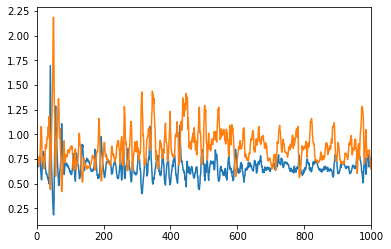

In [ ]:
plt.subplots()
plt.xlim(0,1000)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()

**Showing results**

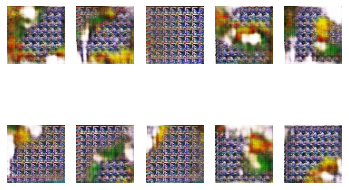

In [ ]:
gan.show_images()


**Saving the model**

In [ ]:
gan.save_model()

Models G//content/drive/MyDrive/ML_HW3/D_model_15000.h5 saved.
